In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from algorithms import ga
from utils import repeat

from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.core.callback import Callback
from pymoo.termination import get_termination

In [28]:
def rosen(X):
  return np.sum((1 - X[:-1]) ** 2 + 100 * (X[1:] - X[:-1] ** 2) ** 2)

rosen_boundaries = lambda x: [(-2.048, 2.048)] * x

## Different NP

In [29]:
NPs = [10, 25, 50, 100]
repetition = 30
F = 0.05
Cr = 0.8

np_experiments = {}
for NP in NPs:
  results = repeat(30, ga.minimize, rosen, rosen_boundaries(2), NP, F, Cr)
  np_experiments[NP] = np.array([list(result) for result in results], dtype=[('best_x', float, (2,)), ('fitness', float)])

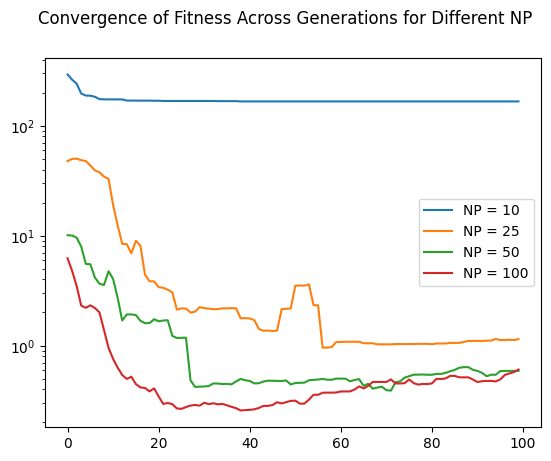

In [30]:
for NP in NPs:
    plt.plot(np.mean(np_experiments[NP]["fitness"], axis=0), label=f"NP = {NP}")

plt.suptitle("Convergence of Fitness Across Generations for Different NP")

plt.legend()
plt.yscale("log")
plt.show()

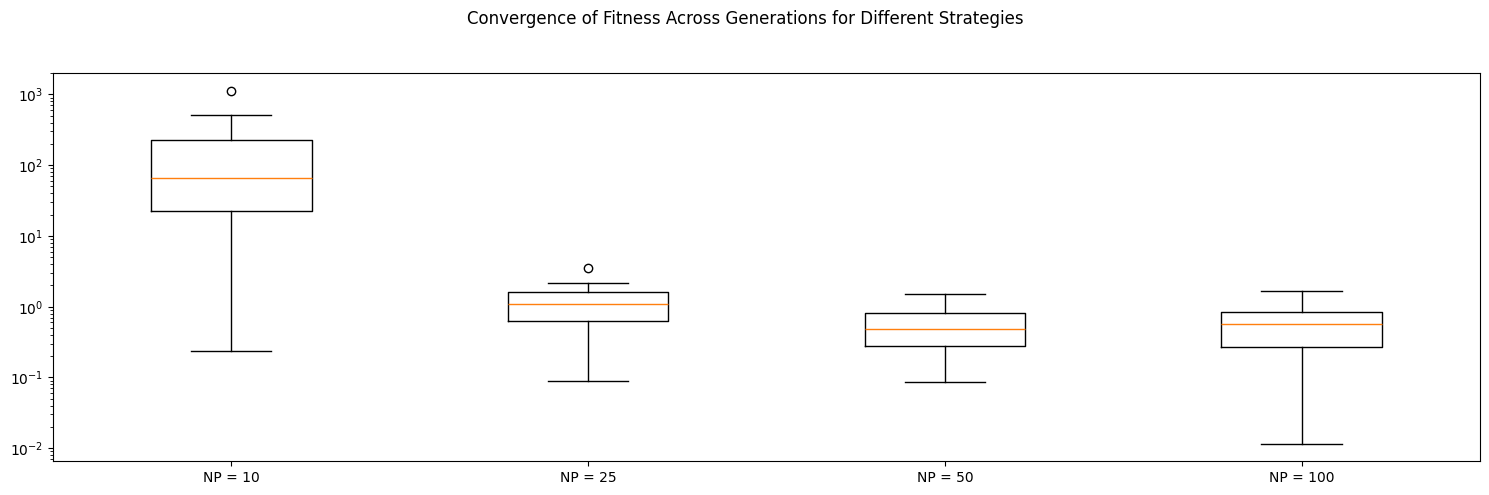

In [31]:
fig = plt.figure(figsize=(15, 5))

data = [np_experiments[NP]["fitness"][:, 99] for NP in NPs]
plt.boxplot(data, labels=[f"NP = {NP}" for NP in NPs])
plt.yscale('log')

fig.suptitle("Convergence of Fitness Across Generations for Different Strategies")
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the main title
plt.show()

## Different Strategies

In [32]:
fmap = {
  "roullete": ga.selection.roullete,
  "tournament": ga.selection.tournament,
  "uniform": ga.mutation.uniform,
  "gaussian": ga.mutation.gaussian,
  }

selection_methods = ["tournament", "roullete"]
mutation_methods = ["uniform", "gaussian"]

repetition = 30
F = 0.05
Cr = 0.8
NP = 100


experiments = {}
for selection in selection_methods:
  experiments[selection] = {}
  for mutation in mutation_methods:
    results = repeat(30, ga.minimize, rosen, rosen_boundaries(2), NP, F, Cr, selection_function=fmap[selection], mutation_function=fmap[mutation])
    experiments[selection][mutation] = np.array([list(result) for result in results], dtype=[('best_x', float, (2,)), ('fitness', float)])

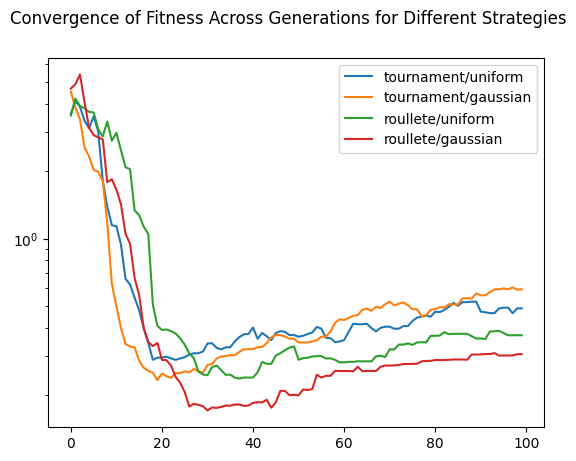

In [33]:
for selection in selection_methods:
  for mutation in mutation_methods:
    plt.plot(np.mean(experiments[selection][mutation]["fitness"], axis=0), label=f"{selection}/{mutation}")

plt.suptitle("Convergence of Fitness Across Generations for Different Strategies")

plt.legend()
plt.yscale("log")
plt.show()

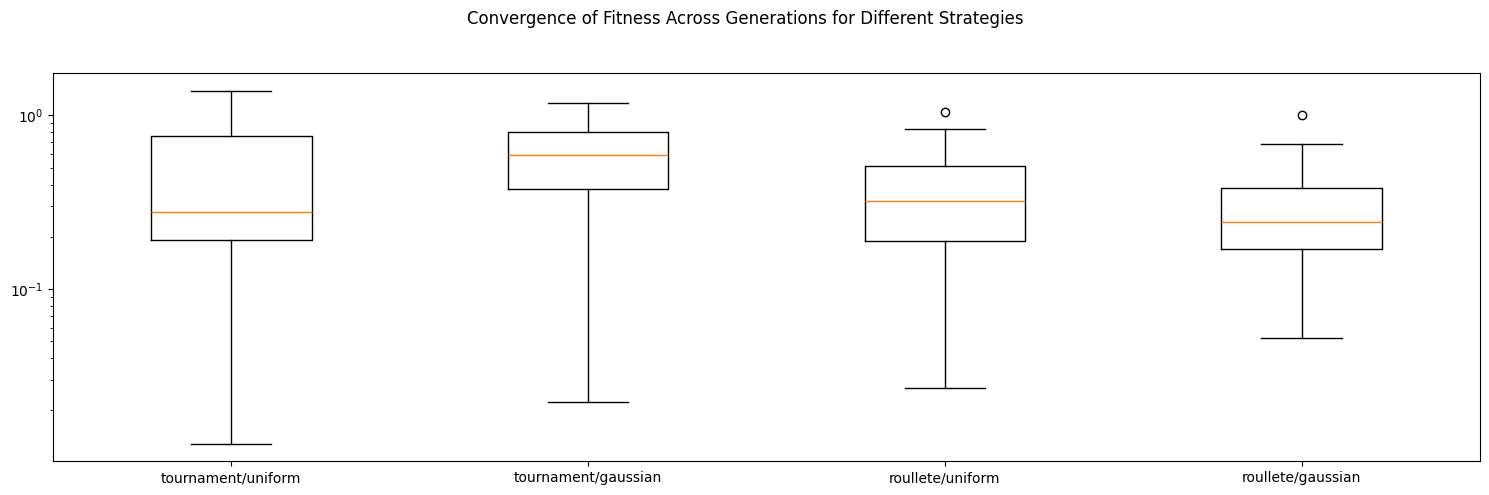

In [34]:
fig = plt.figure(figsize=(15, 5))

data = [experiments[selection][mutation]["fitness"][:, 99] for selection in selection_methods for mutation in mutation_methods]
plt.boxplot(data, labels=[f"{selection}/{mutation}" for selection in selection_methods for mutation in mutation_methods])
plt.yscale('log')

fig.suptitle("Convergence of Fitness Across Generations for Different Strategies")
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the main title
plt.show()

## PyMoo Comparison

In [17]:
class SavePopulationCallback(Callback):
    def __init__(self):
        super().__init__()
        self.data = []

    def notify(self, algorithm):
        # append the deep copy of current population to data list
        best_idx = np.argmin(algorithm.pop.get("F"))
        best_x = np.float32(algorithm.pop.get("X")[best_idx])
        best_f = np.float32(algorithm.pop.get("F")[best_idx])
        self.data.append((best_x, best_f))



problem = get_problem("rosenbrock", n_var=2)

pymoo_ga = GA(
    pop_size=100,
    eliminate_duplicates=True,
    max_gen=100)

termination = get_termination("n_gen", 100)
ga_pymoo_experiments = []

for i in range(30):
  callback = SavePopulationCallback()
  res = minimize(problem,
                pymoo_ga,
                termination=termination,
                seed=np.random.randint(0, 10000),
                callback=callback)
  ga_pymoo_experiments.append(callback.data)


ga_pymoo_experiments = np.array(ga_pymoo_experiments, dtype=[('best_x', float, (2,)), ('fitness', float)])
      

/var/folders/qk/qhpk8_352d1gw4g1s3r0mlrm0000gn/T/ipykernel_34495/3708073697.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ga_pymoo_experiments = np.array(ga_pymoo_experiments, dtype=[('best_x', float, (2,)), ('fitness', float)])


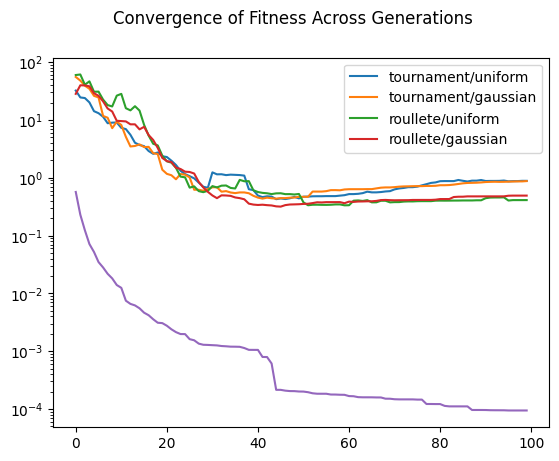

In [21]:
for selection in selection_methods:
  for mutation in mutation_methods:
    plt.plot(np.mean(experiments[selection][mutation]["fitness"], axis=0), label=f"{selection}/{mutation}")
    
plt.plot(np.mean(ga_pymoo_experiments["fitness"], axis=0))

plt.suptitle("Convergence of Fitness Across Generations")

plt.legend()
plt.yscale("log")
plt.show()

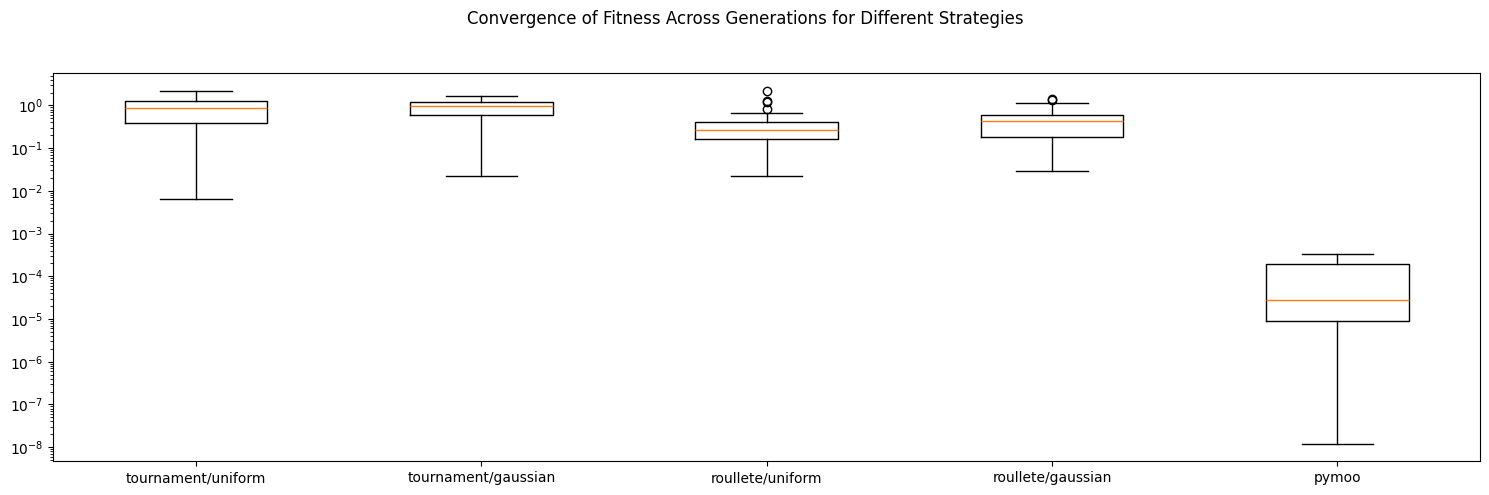

In [20]:
fig = plt.figure(figsize=(15, 5))

data = [experiments[selection][mutation]["fitness"][:, 99] 
        for selection in selection_methods 
        for mutation in mutation_methods] + [ga_pymoo_experiments["fitness"][:, 99]]

labels = [f"{selection}/{mutation}" for selection in selection_methods for mutation in mutation_methods] + ["pymoo"]
plt.boxplot(data, labels=labels)
plt.yscale('log')

fig.suptitle("Convergence of Fitness Across Generations for Different Strategies")
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the main title
plt.show()